# Preprocessing of Single-cell RNA Sequencing data
Training Dataset  
Julia Kuhn

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import anndata

from statsmodels.stats.multitest import multipletests
from scipy.stats import median_abs_deviation
from scipy.stats import skew
from scipy.sparse import issparse

In [2]:
# open raw count matrices
file = "/home/jkuhn/Bachelors-Thesis/input/CountAdded_PIP_global_object_for_cellxgene1.h5ad"
adata = sc.read_h5ad(file)
adata.var_names_make_unique()
adata # printing the AnnData object after every steps to show changes in its structure

AnnData object with n_obs × n_vars = 329762 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

# Dataset Distribution

In [3]:
adata.obs["Cell_category"].value_counts()

Cell_category
ILCT              216611
B                  54934
Myeloid            51552
Mast                3291
Progenitor          1518
pDC                  713
Ery                  445
MNP/T_doublets       325
Mgk                  317
B/T_doublets          56
Name: count, dtype: int64

In [4]:
adata.obs["Majority_voting_CellTypist_high"].value_counts()

Majority_voting_CellTypist_high
T cells           183796
B cells            45802
ILC                32539
Monocytes          25611
Macrophages        23472
Plasma cells        8645
Mast cells          3327
DC                  1668
HSC/MPP             1505
Cycling cells       1054
pDC                  791
Promyelocytes        767
Erythroid            443
Early MK             242
B-cell lineage       100
Name: count, dtype: int64

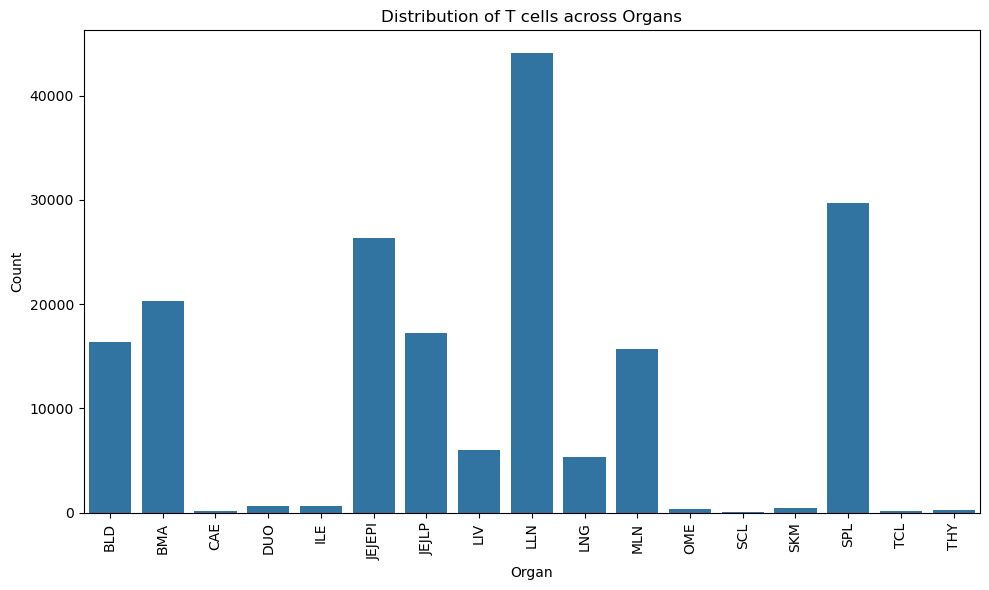

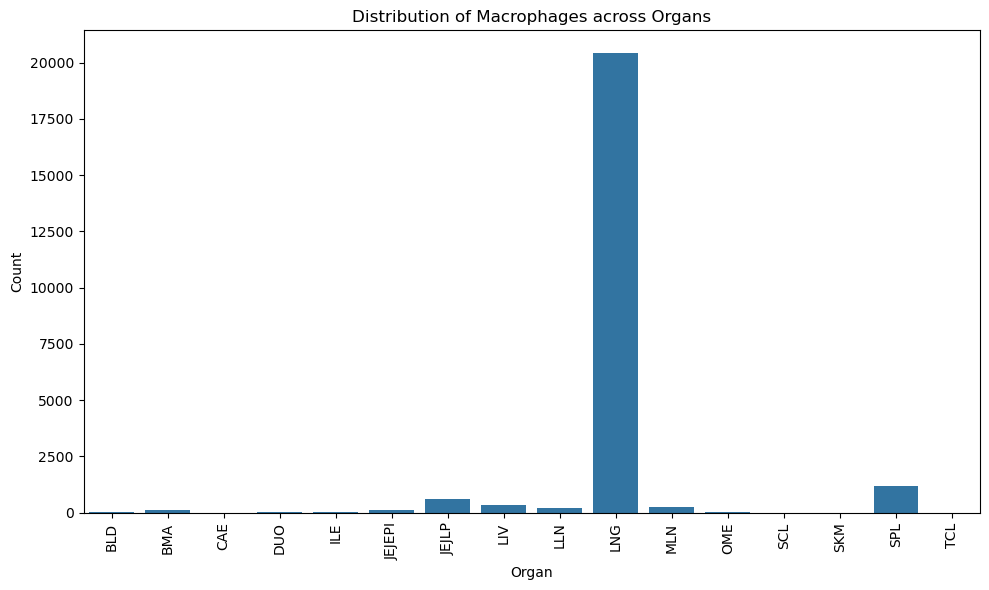

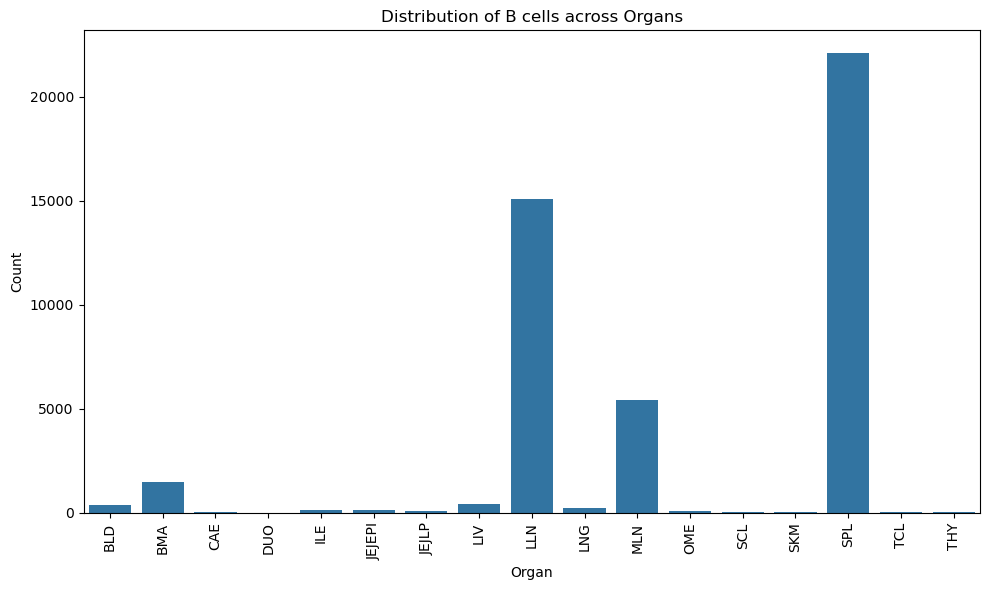

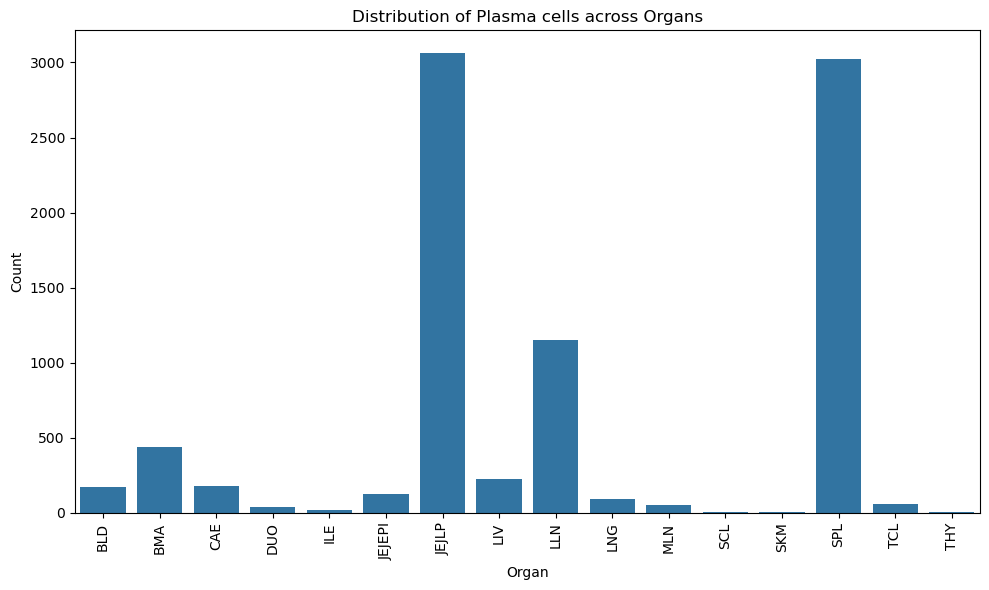

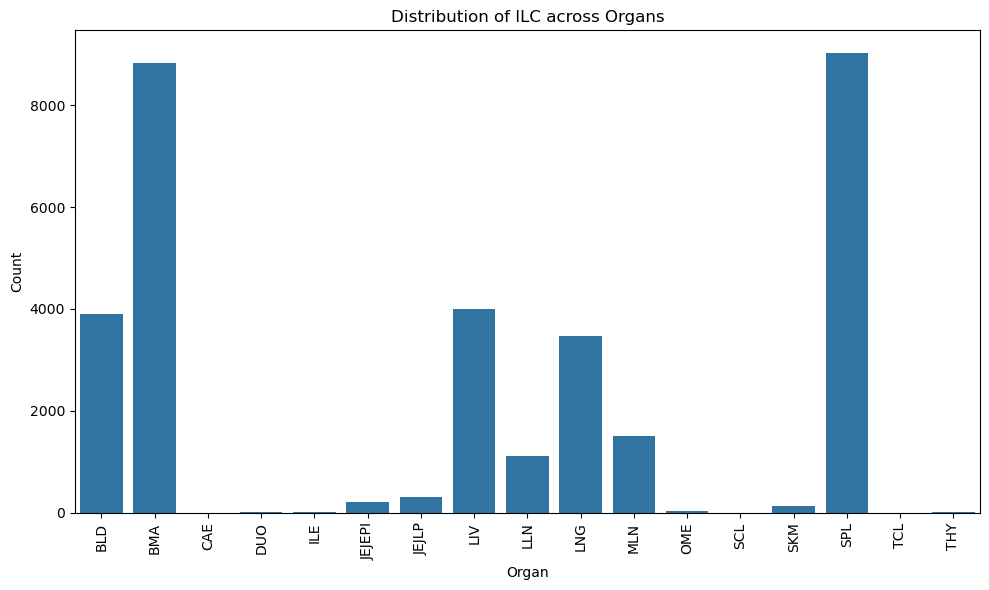

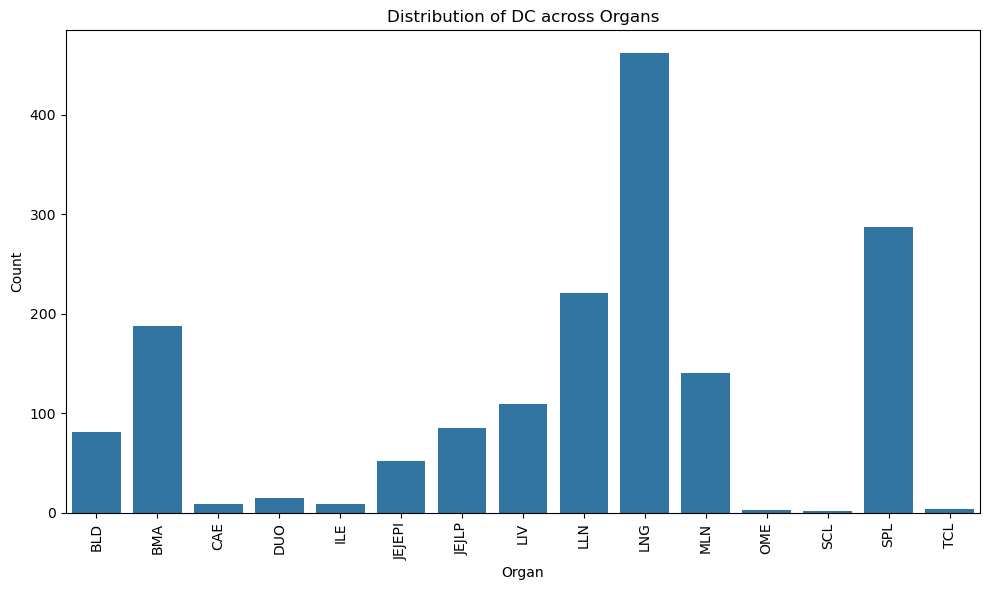

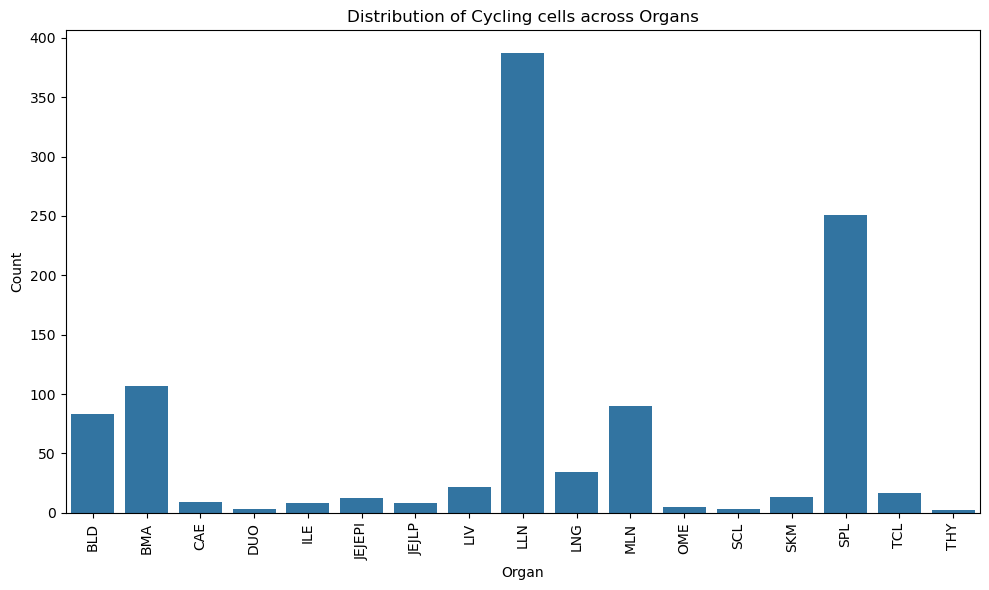

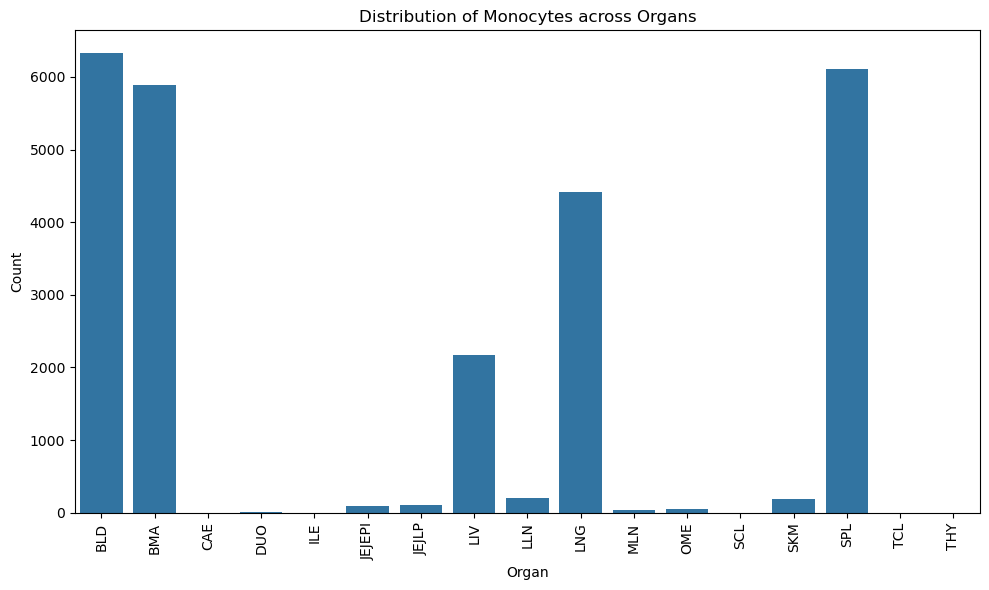

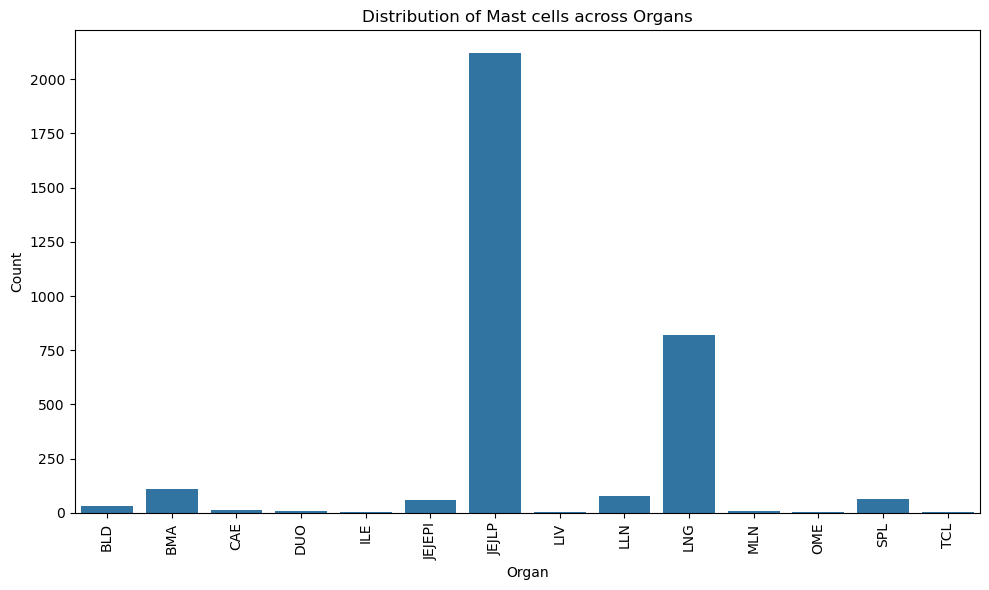

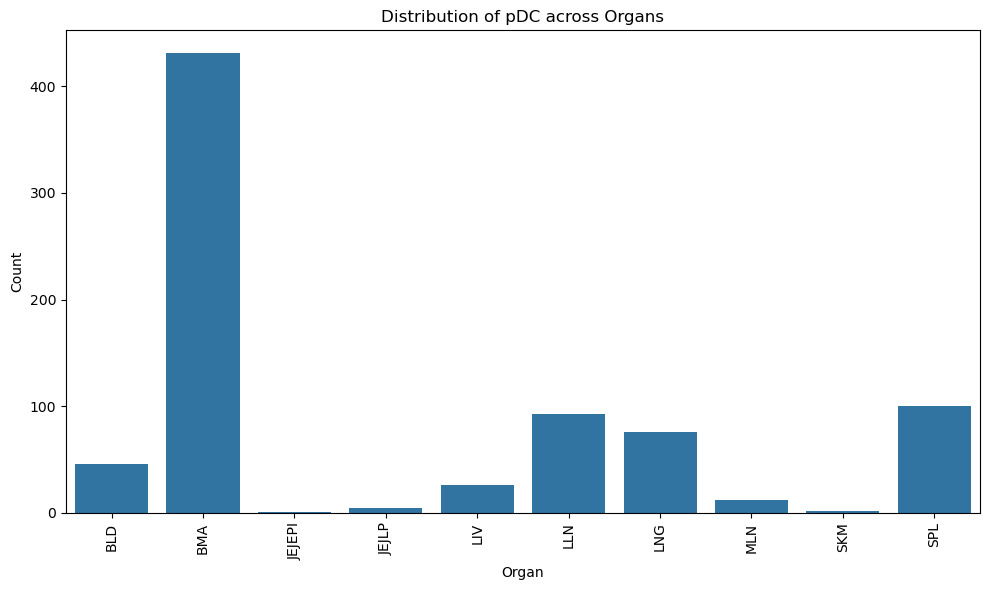

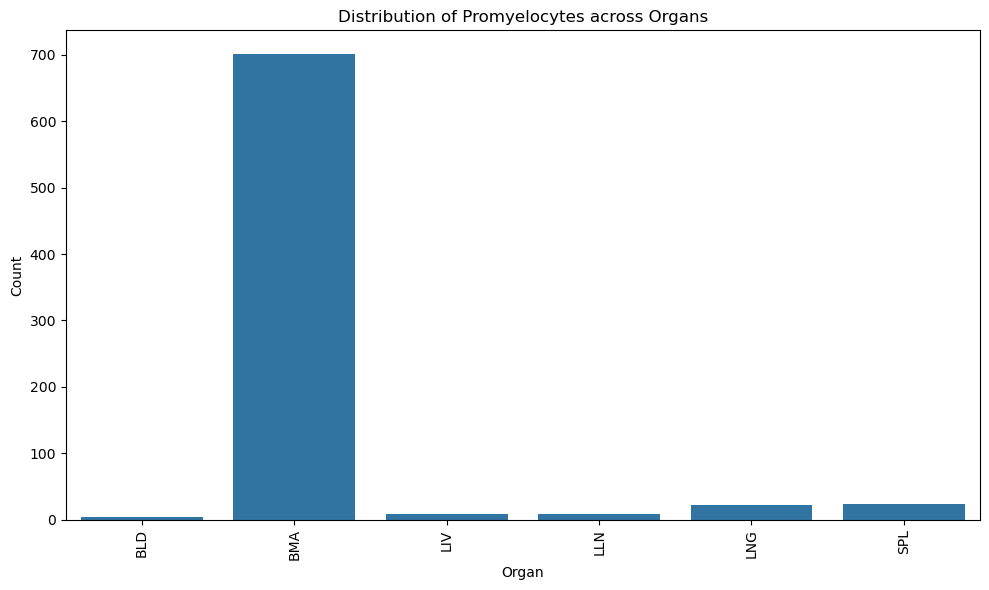

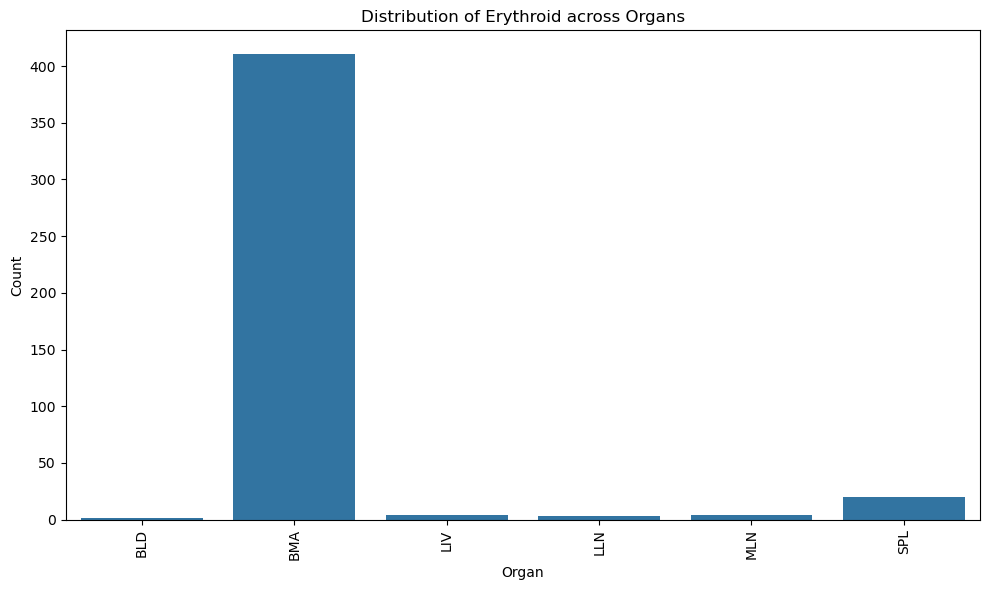

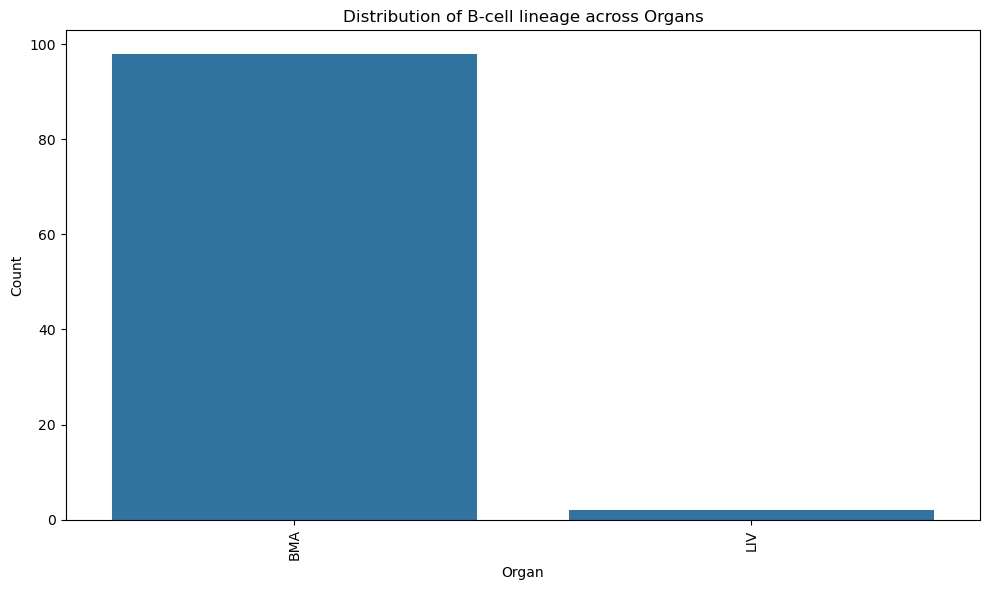

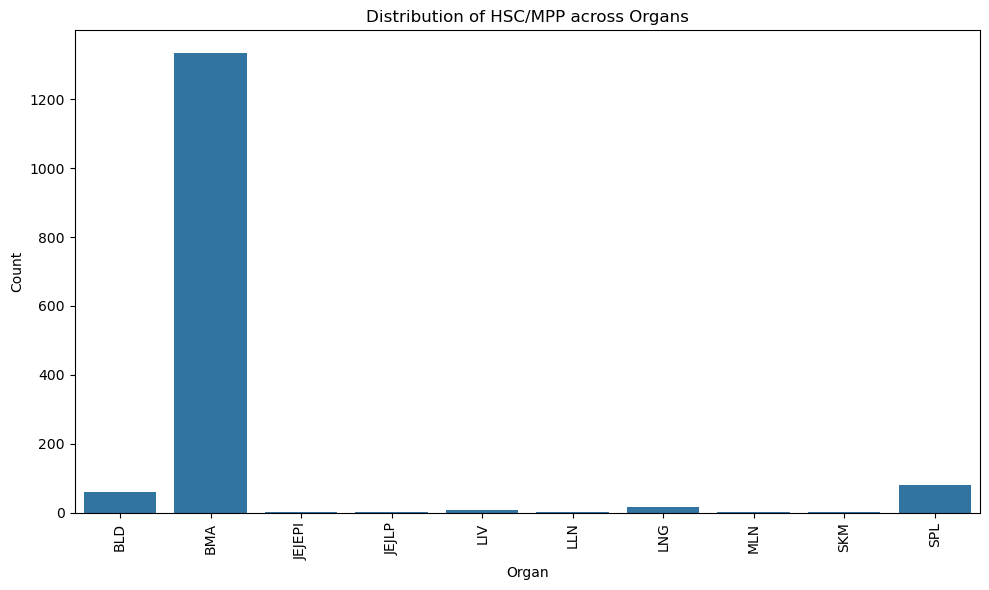

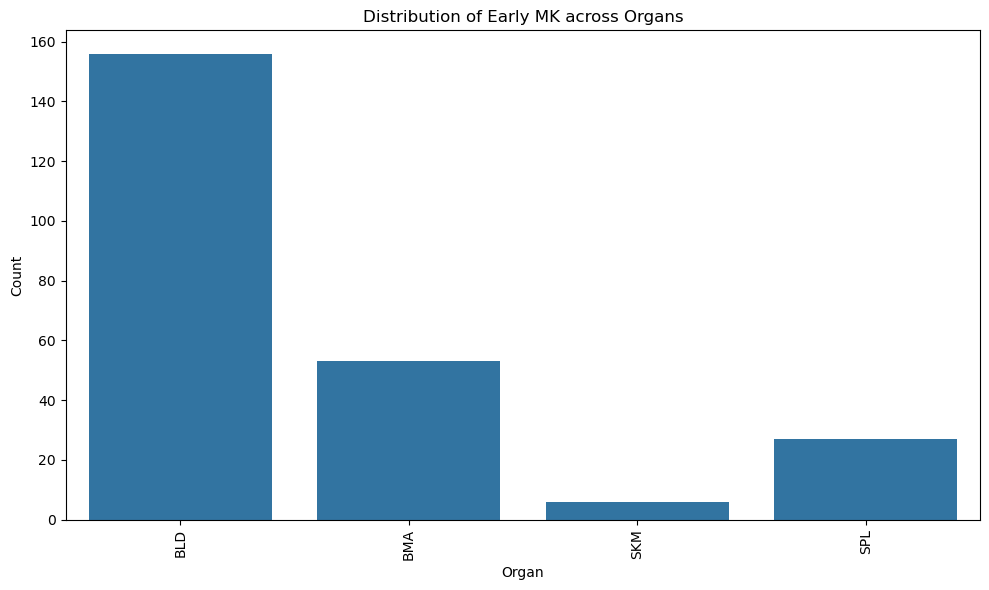

In [5]:
# Iterate through each cell type
for celltype in adata.obs["Majority_voting_CellTypist_high"].unique():
    # Filter the data for the current cell type
    adata_ilct = adata[(adata.obs["Majority_voting_CellTypist_high"] == celltype)].copy()
    
    # Count the occurrences of each organ for the current cell type
    organ_counts = adata_ilct.obs["Organ"].value_counts().reset_index()
    organ_counts.columns = ['Organ', 'Count']
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Organ', y='Count', data=organ_counts)
    plt.title(f'Distribution of {celltype} across Organs')
    plt.xlabel('Organ')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

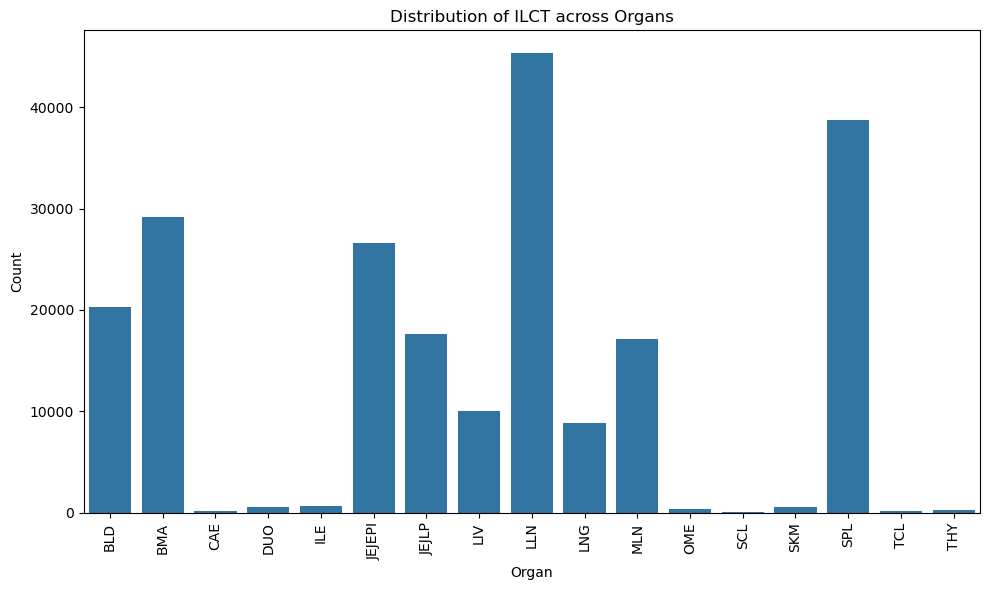

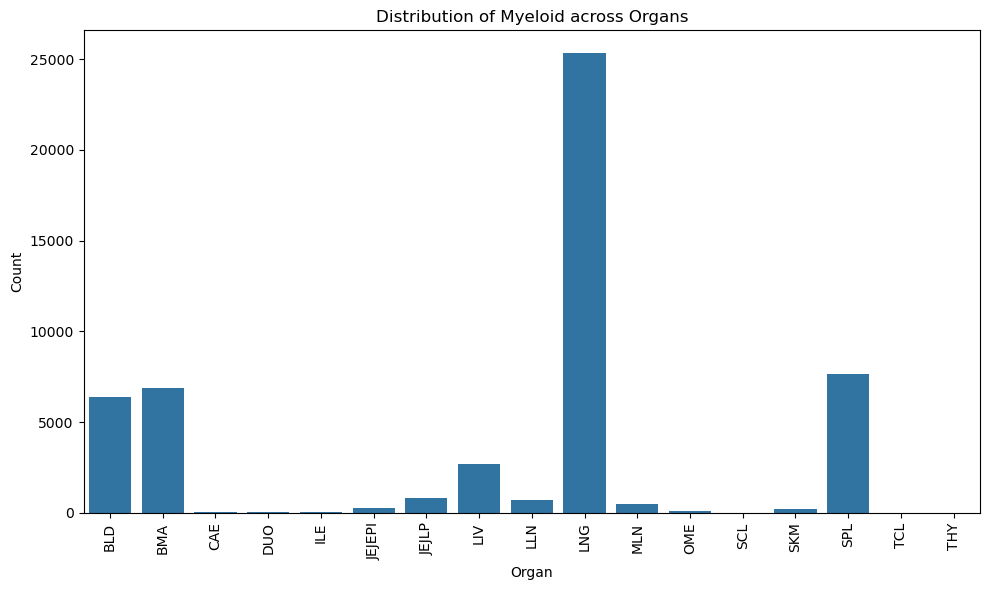

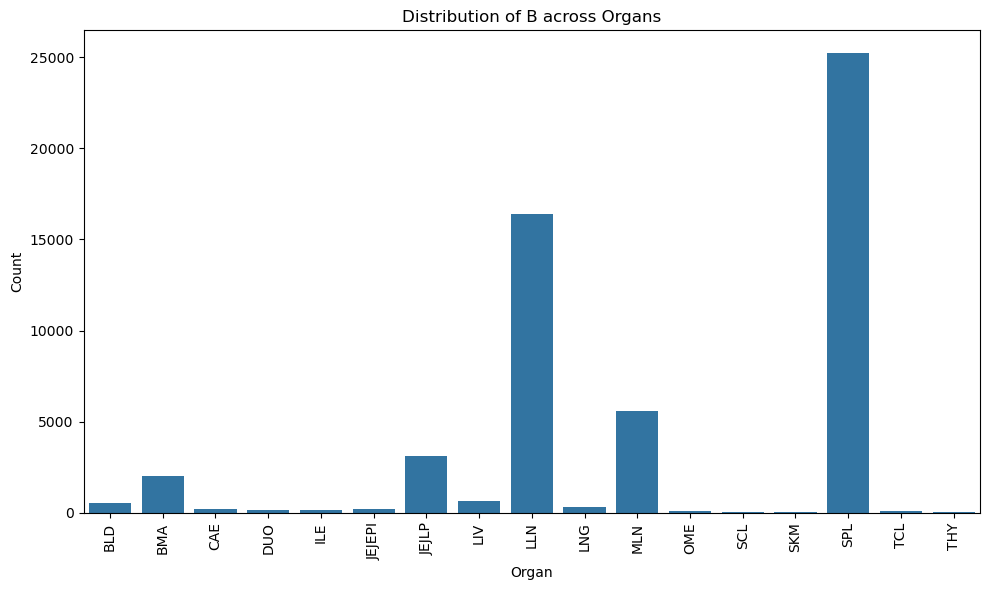

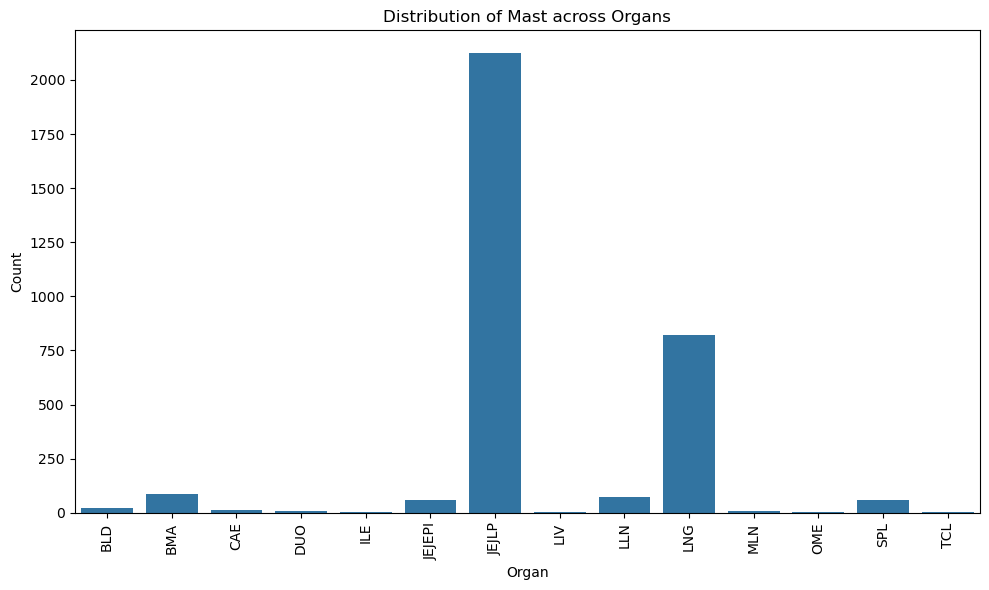

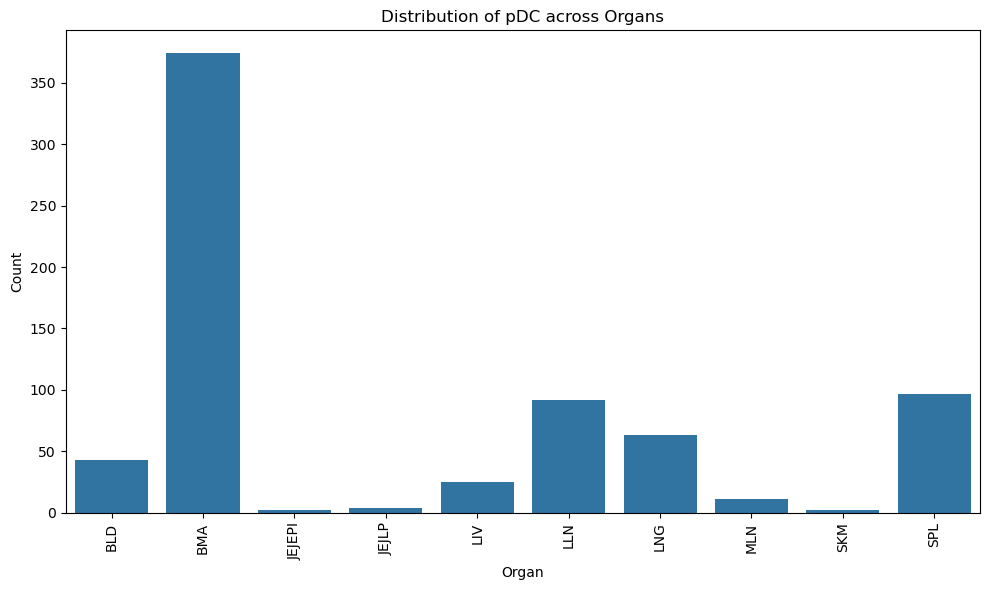

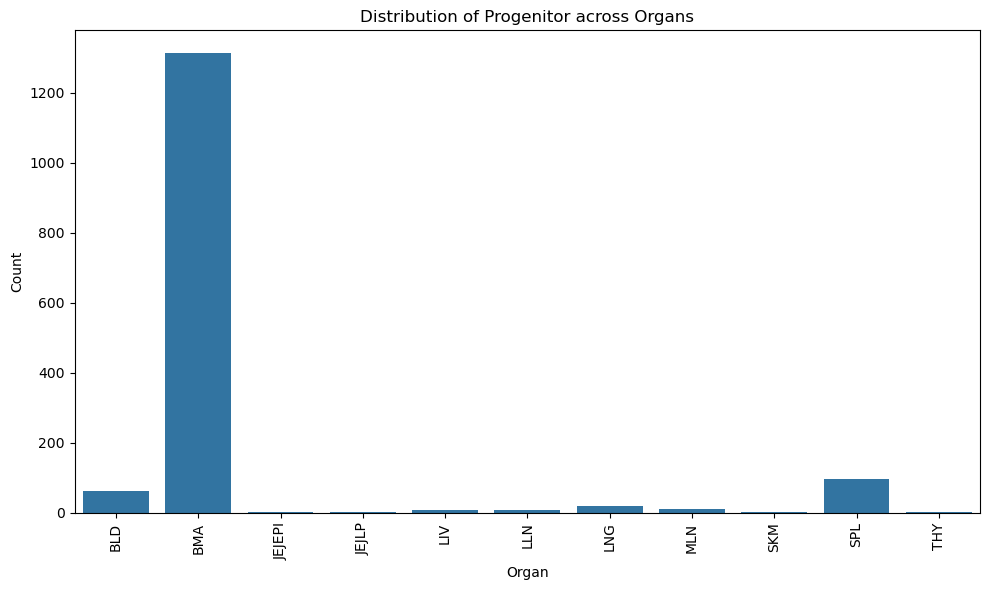

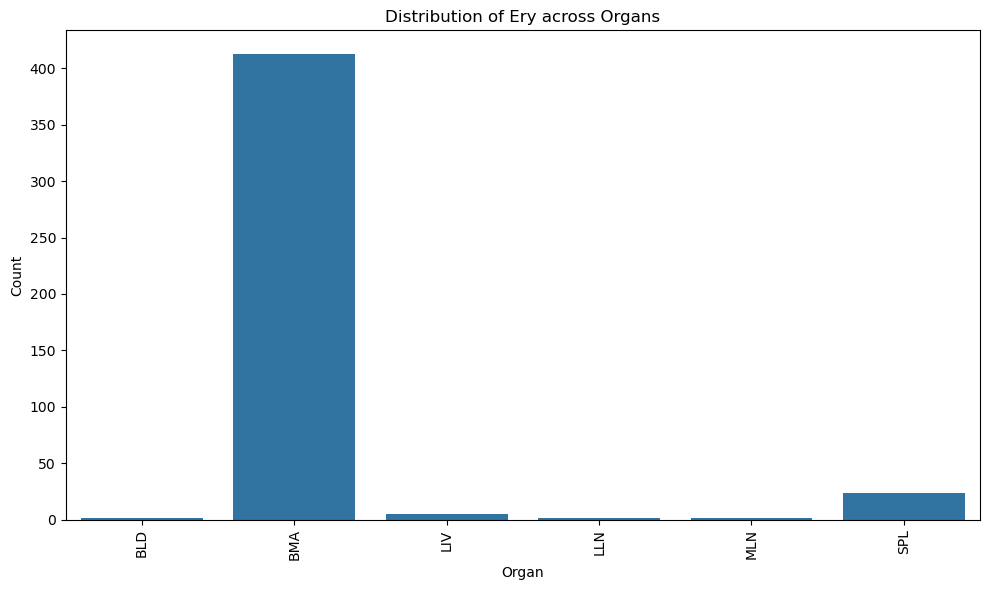

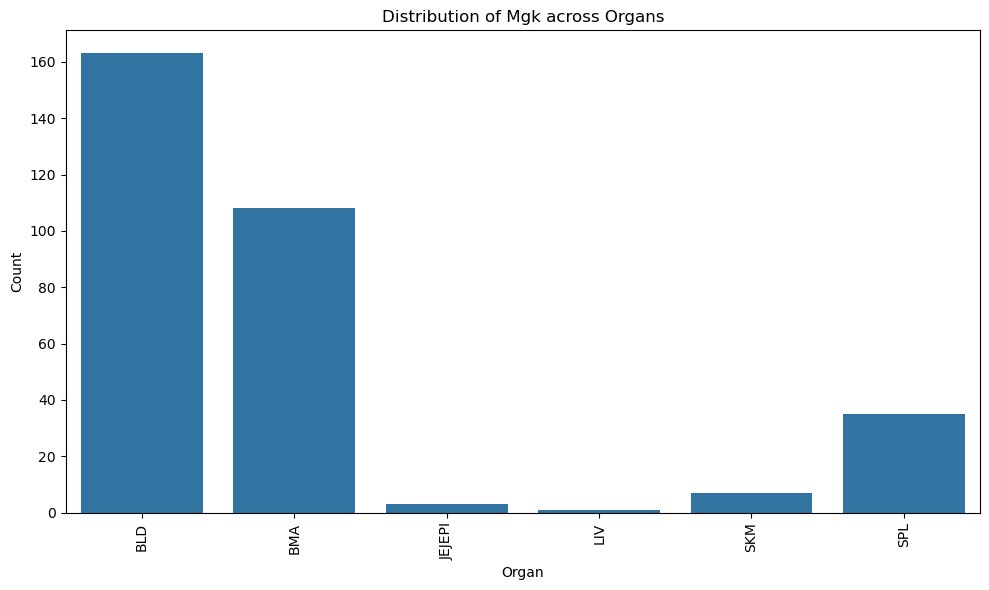

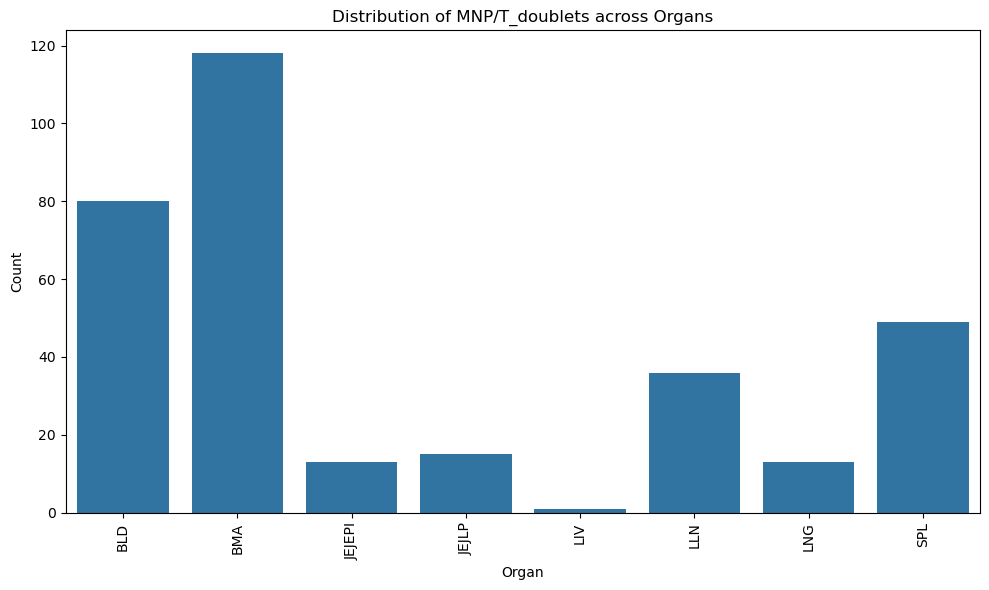

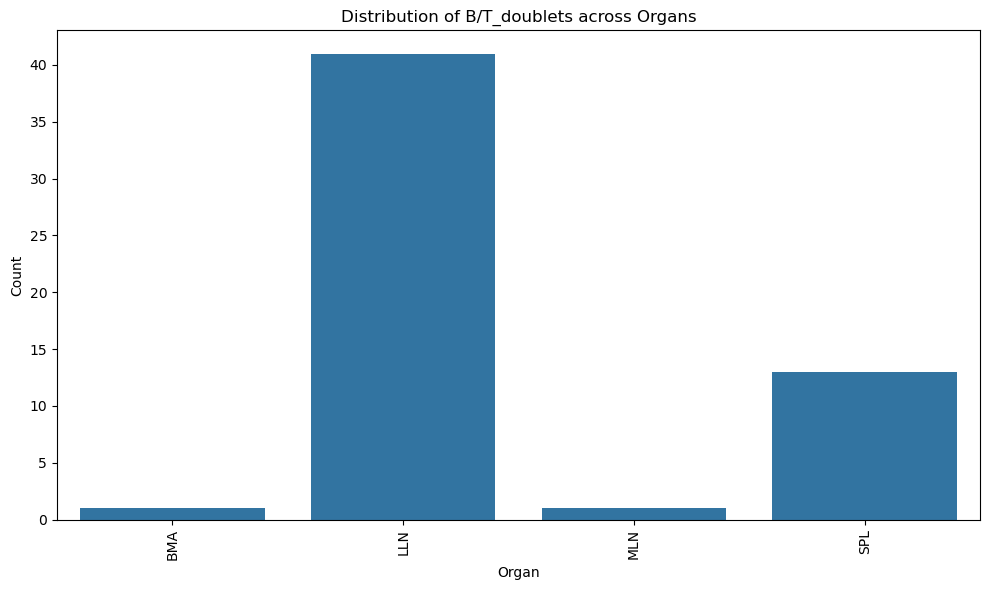

In [6]:
# Iterate through each cell type
for celltype in adata.obs["Cell_category"].unique():
    # Filter the data for the current cell type
    adata_ilct = adata[(adata.obs["Cell_category"] == celltype)].copy()
    
    # Count the occurrences of each organ for the current cell type
    organ_counts = adata_ilct.obs["Organ"].value_counts().reset_index()
    organ_counts.columns = ['Organ', 'Count']
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Organ', y='Count', data=organ_counts)
    plt.title(f'Distribution of {celltype} across Organs')
    plt.xlabel('Organ')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Quality Control

In [7]:
# annotating the group of mitochondrial, ribosomal, and hemoglobin genes 

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

# calculate the respective qc metrics with scanpy
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top= [20], log1p=True
)

adata

AnnData object with n_obs × n_vars = 329762 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'Sex', 'Age_range', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


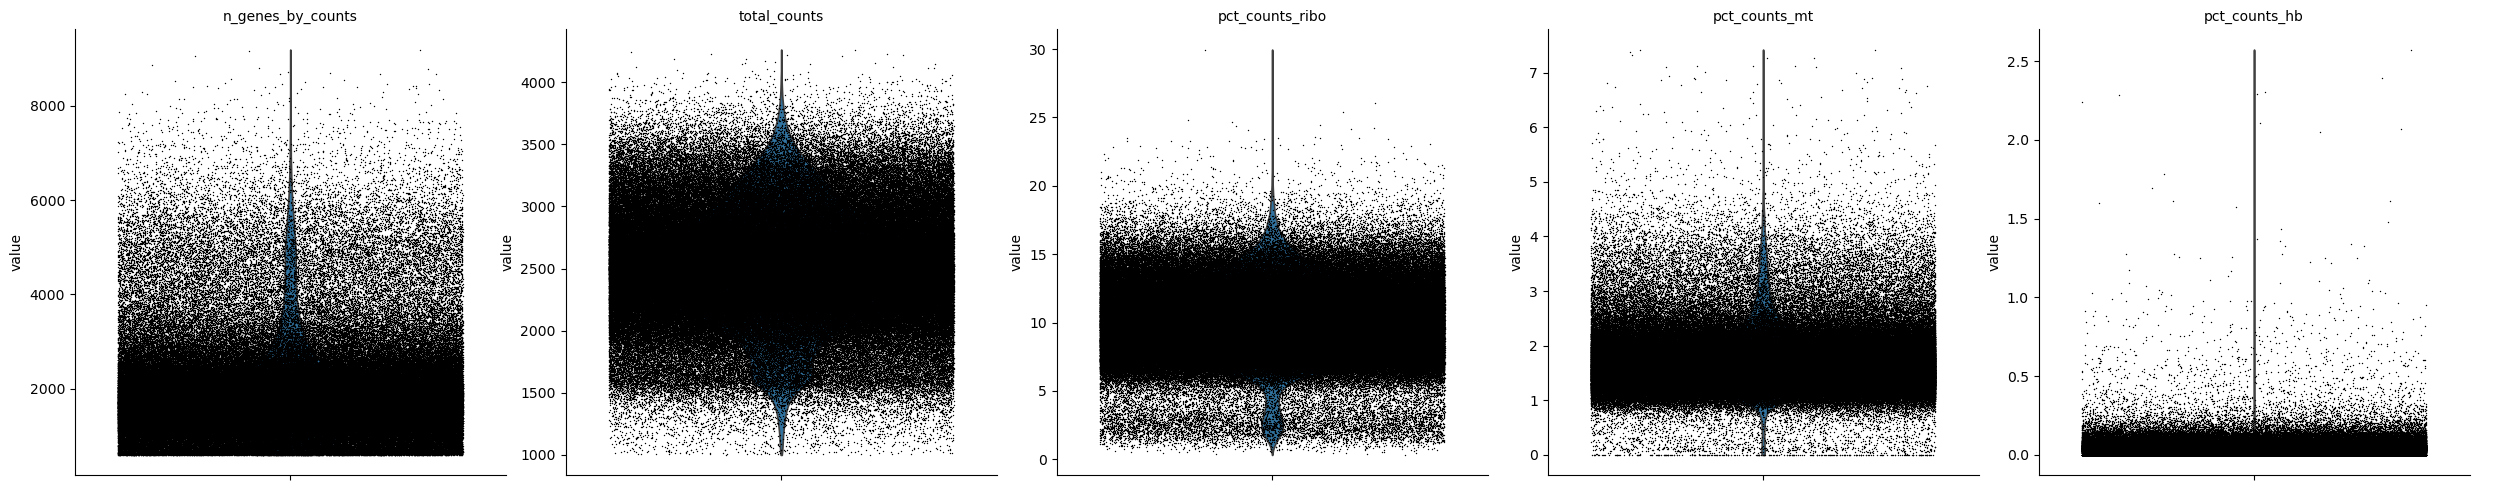

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_ribo', 'pct_counts_mt', 'pct_counts_hb'],
             jitter=0.4, multi_panel=True)

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


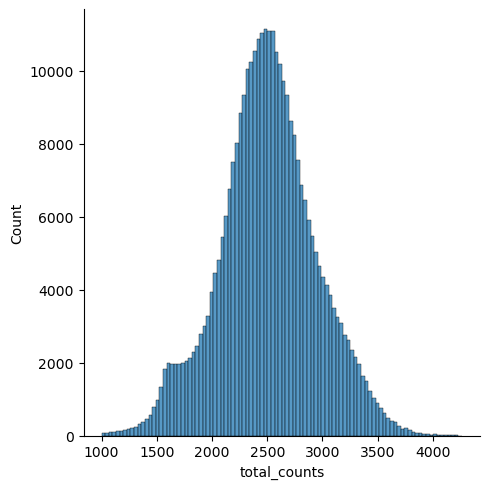

In [9]:
p2 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)

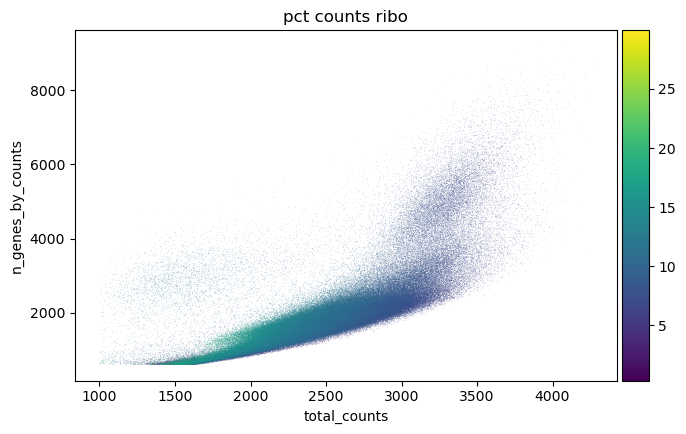

In [10]:
p2 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_ribo")

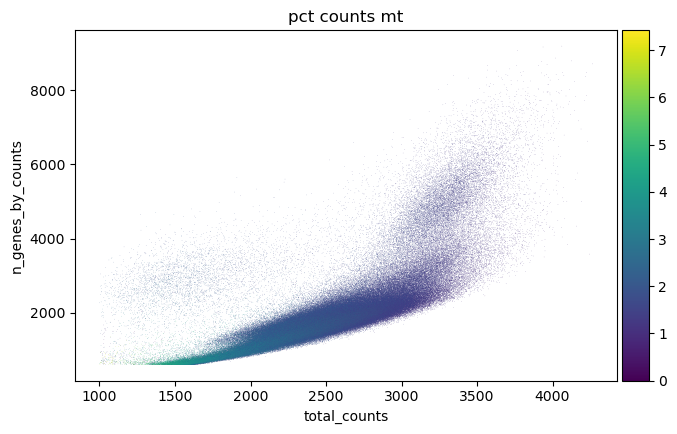

In [11]:

p2 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

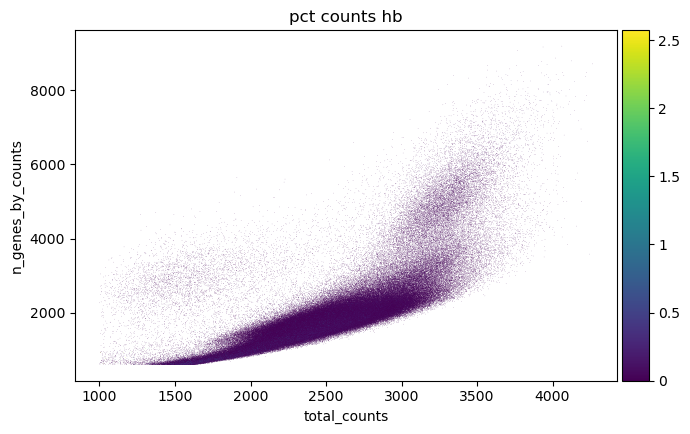

In [12]:
p2 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_hb")

In [13]:
# Perform highly variable genes analysis
sc.pp.highly_variable_genes(adata, n_top_genes=1000, inplace=True)

# Extract the top 2,000 HVGs
top_hvgs = adata.var_names[adata.var['highly_variable']]

# Get the names of the 5 highest and 5 lowest HVGs
highest_hvgs = top_hvgs[:5].tolist()
lowest_hvgs = top_hvgs[-5:].tolist()

# Print the results
print("The top 5 Highly Variable Genes are:")
print(highest_hvgs)

print("\n The bottom 5 Highly Variable Genes are:")
print(lowest_hvgs)

The top 5 Highly Variable Genes are:
['TNFRSF4', 'AL354743.1', 'LRRC38', 'HSPB7', 'PLA2G2A']

 The bottom 5 Highly Variable Genes are:
['MT-ND4L', 'AC233755.2', 'AC233755.1', 'AC136616.3', 'AC141272.1']


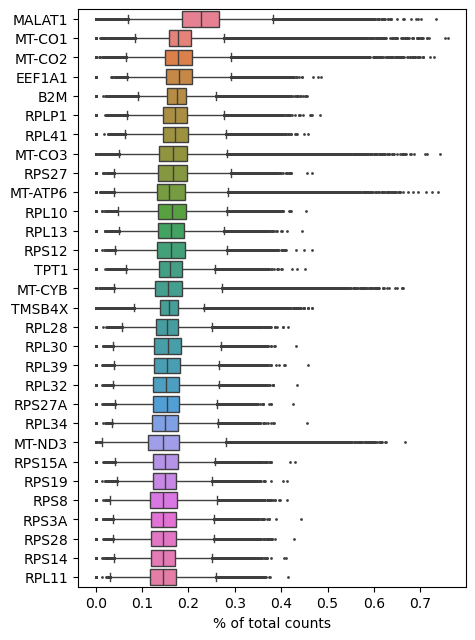

In [14]:
# Visualization: the genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=30)

Mean of means: 0.06845627725124359
Standard deviation of means: 0.2400808036327362
Mean of standard deviations: 0.1363963633775711
Standard deviation of standard deviations: 0.19747589528560638


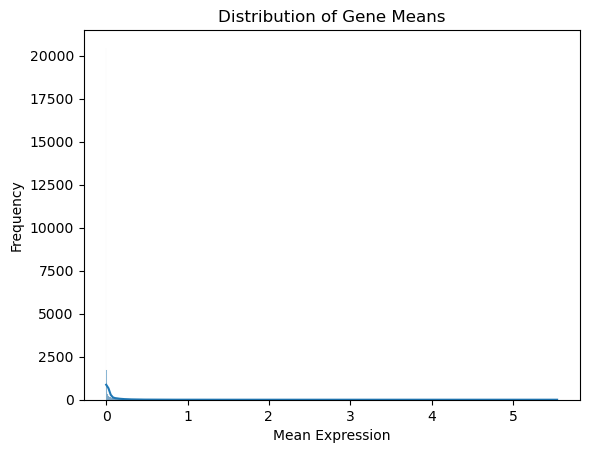

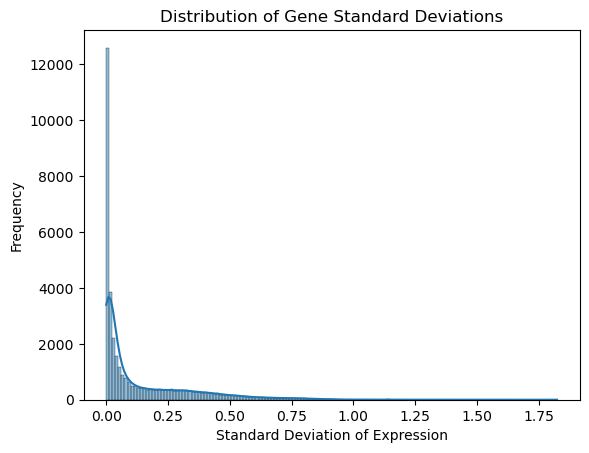

In [15]:
# check whether the data is skaled
if issparse(adata.X):
    X_dense = adata.X.toarray()
else:
    X_dense = adata.X

# Compute the mean and standard deviation for each gene
means = np.mean(X_dense, axis=0)
stds = np.std(X_dense, axis=0)

# Print summary statistics
print(f'Mean of means: {np.mean(means)}')
print(f'Standard deviation of means: {np.std(means)}')
print(f'Mean of standard deviations: {np.mean(stds)}')
print(f'Standard deviation of standard deviations: {np.std(stds)}')

# Visualize
sns.histplot(means, kde=True)
plt.title('Distribution of Gene Means')
plt.xlabel('Mean Expression')
plt.ylabel('Frequency')
plt.show()

sns.histplot(stds, kde=True)
plt.title('Distribution of Gene Standard Deviations')
plt.xlabel('Standard Deviation of Expression')
plt.ylabel('Frequency')
plt.show()

# Principal Component Analyis (PCA) for Dimensionality Reduction

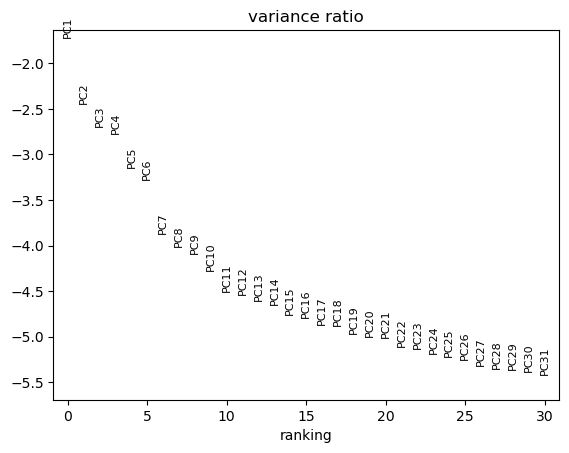

In [16]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
# Elbow plot
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=30)

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


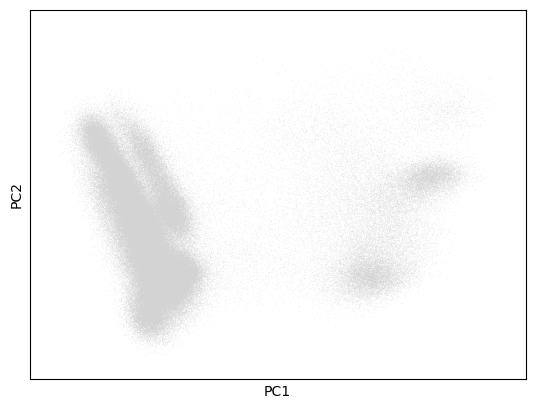

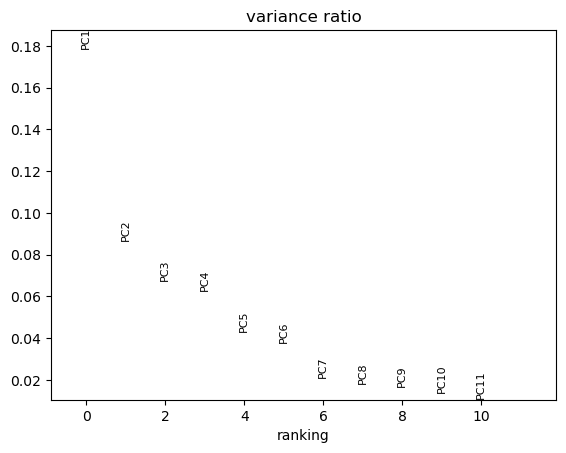

In [17]:
sc.tl.pca(adata, n_comps=11) # Perform PCA
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=11)

Initially, the data is duplicated for conducting a PCA to identify the top PCs based on the elbow plot. Subsequently, PCA is executed using the selected number of PCs. Restricting the analysis to these identified PCs significantly reduces dimensionality, thereby enhancing computational efficiency for downstream tasks.

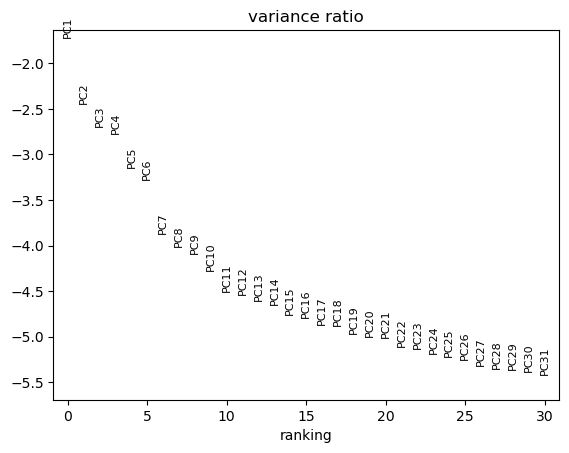

In [18]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
# Elbow plot
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=30)

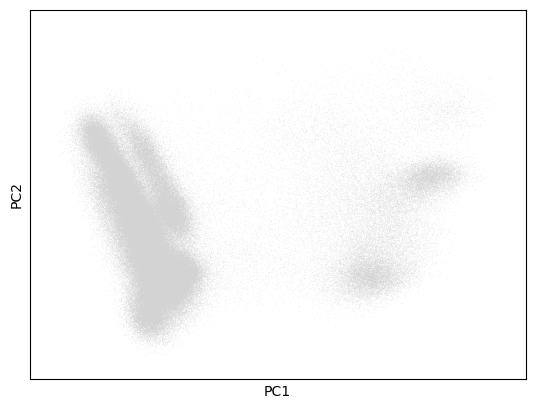

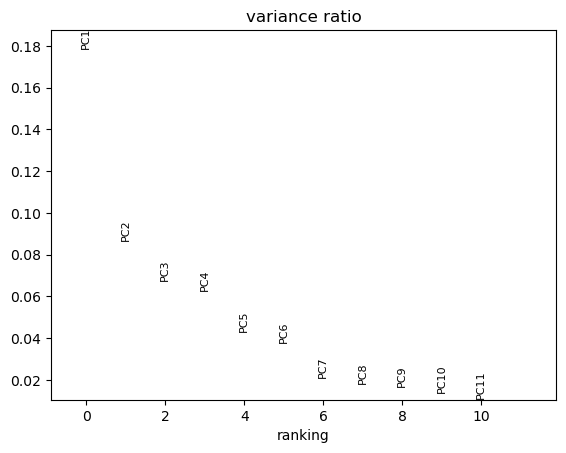

In [19]:
sc.tl.pca(adata, n_comps=11) # Perform PCA
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=11)

### 6. Clustering

In [20]:
# KNN calculation
sc.pp.neighbors(adata, n_pcs=11)
sc.tl.leiden(adata)
sc.tl.umap(adata)

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/umap/d

# Visualizations

## UMAPS

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


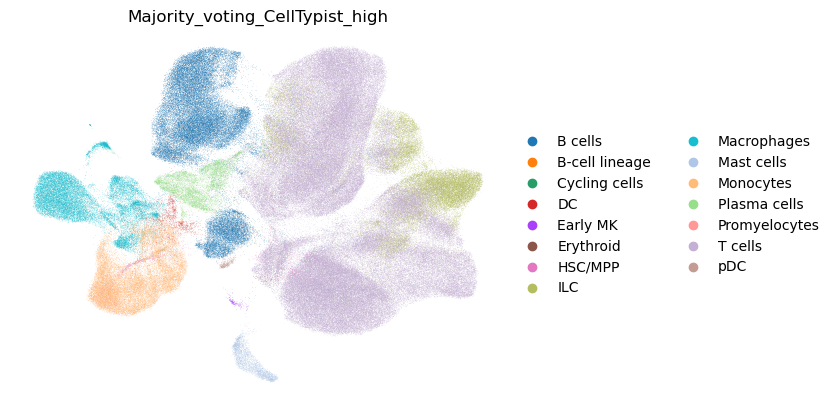

In [21]:
sc.pl.umap(
    adata,
    color=["Majority_voting_CellTypist_high"],
    frameon=False,
)

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


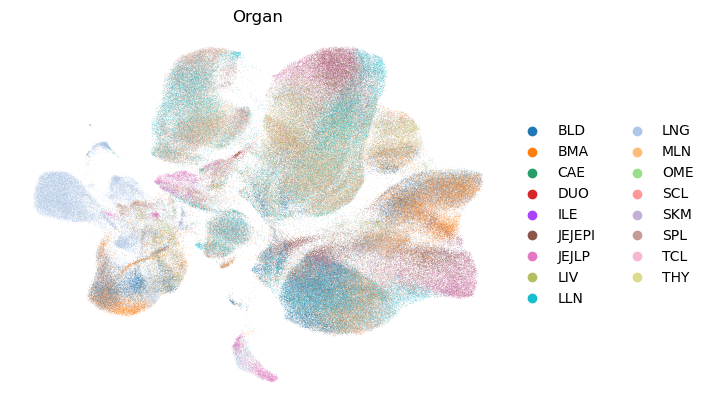

In [22]:
sc.pl.umap(
    adata,
    color=["Organ"],
    frameon=False,
)

### UMAPS for only t cells

In [23]:
adata_t = adata[adata.obs["Majority_voting_CellTypist_high"] == "T cells"]

In [24]:
# KNN calculation
sc.pp.neighbors(adata_t, n_pcs=11)
sc.tl.leiden(adata_t)
sc.tl.umap(adata_t)

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


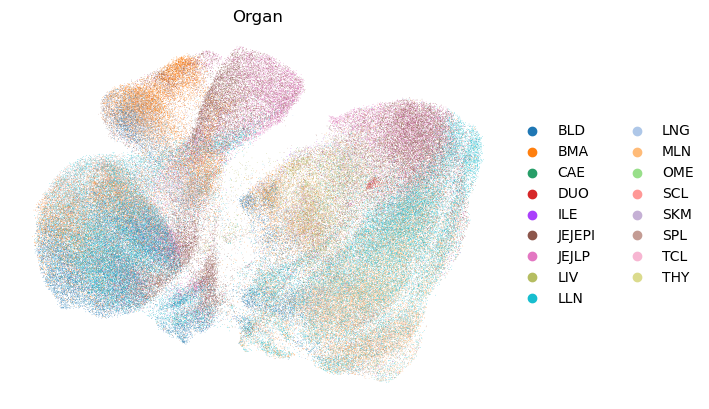

In [25]:
sc.pl.umap(
    adata_t,
    color=["Organ"],
    frameon=False,
)

## Rank Gene Groups

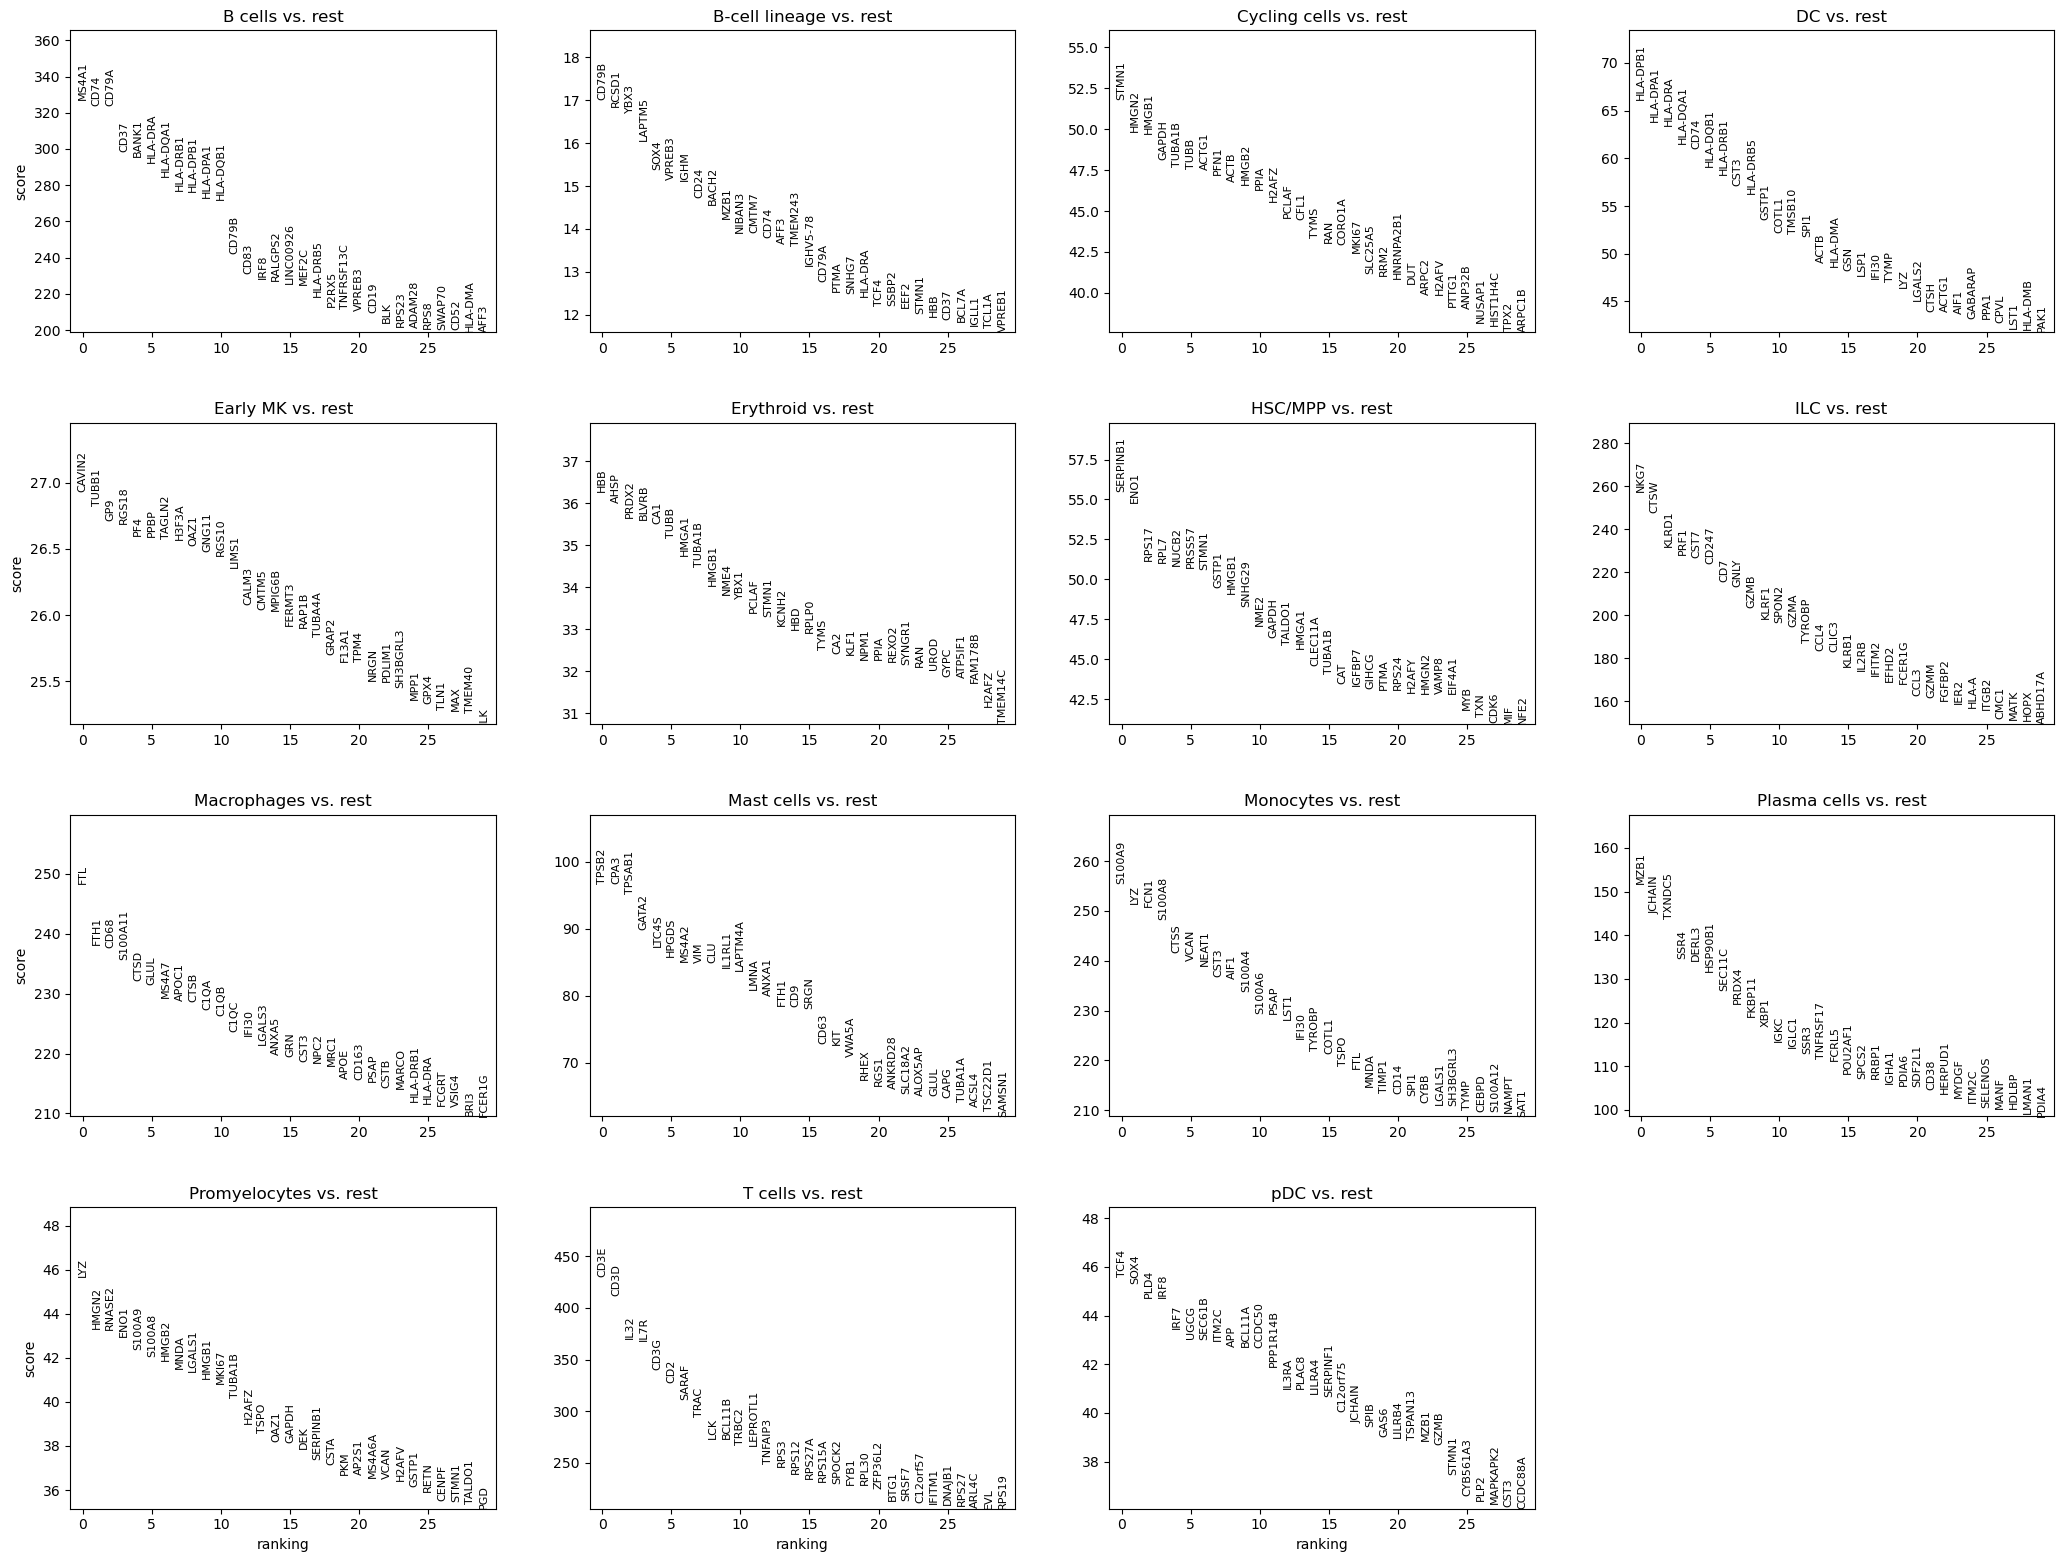

Top 5 genes for B cells: ['MS4A1' 'CD74' 'CD79A' 'CD37' 'BANK1']
Top 5 genes for B-cell lineage: ['CD79B' 'RCSD1' 'YBX3' 'LAPTM5' 'SOX4']
Top 5 genes for Cycling cells: ['STMN1' 'HMGN2' 'HMGB1' 'GAPDH' 'TUBA1B']
Top 5 genes for DC: ['HLA-DPB1' 'HLA-DPA1' 'HLA-DRA' 'HLA-DQA1' 'CD74']
Top 5 genes for Early MK: ['CAVIN2' 'TUBB1' 'GP9' 'RGS18' 'PF4']
Top 5 genes for Erythroid: ['HBB' 'AHSP' 'PRDX2' 'BLVRB' 'CA1']
Top 5 genes for HSC/MPP: ['SERPINB1' 'ENO1' 'RPS17' 'RPL7' 'NUCB2']
Top 5 genes for ILC: ['NKG7' 'CTSW' 'KLRD1' 'PRF1' 'CST7']
Top 5 genes for Macrophages: ['FTL' 'FTH1' 'CD68' 'S100A11' 'CTSD']
Top 5 genes for Mast cells: ['TPSB2' 'CPA3' 'TPSAB1' 'GATA2' 'LTC4S']
Top 5 genes for Monocytes: ['S100A9' 'LYZ' 'FCN1' 'S100A8' 'CTSS']
Top 5 genes for Plasma cells: ['MZB1' 'JCHAIN' 'TXNDC5' 'SSR4' 'DERL3']
Top 5 genes for Promyelocytes: ['LYZ' 'HMGN2' 'RNASE2' 'ENO1' 'S100A9']
Top 5 genes for T cells: ['CD3E' 'CD3D' 'IL32' 'IL7R' 'CD3G']
Top 5 genes for pDC: ['TCF4' 'SOX4' 'PLD4' 'IRF8'

In [26]:
sc.tl.rank_genes_groups(adata, 'Majority_voting_CellTypist_high', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

# Extract the ranked genes
result = adata.uns['rank_genes_groups']

# Loop through each cell type and print the top 5 genes
for cell_type in result['names'].dtype.names:
    top_genes = result['names'][cell_type][:5]
    print(f"Top 5 genes for {cell_type}: {top_genes}")

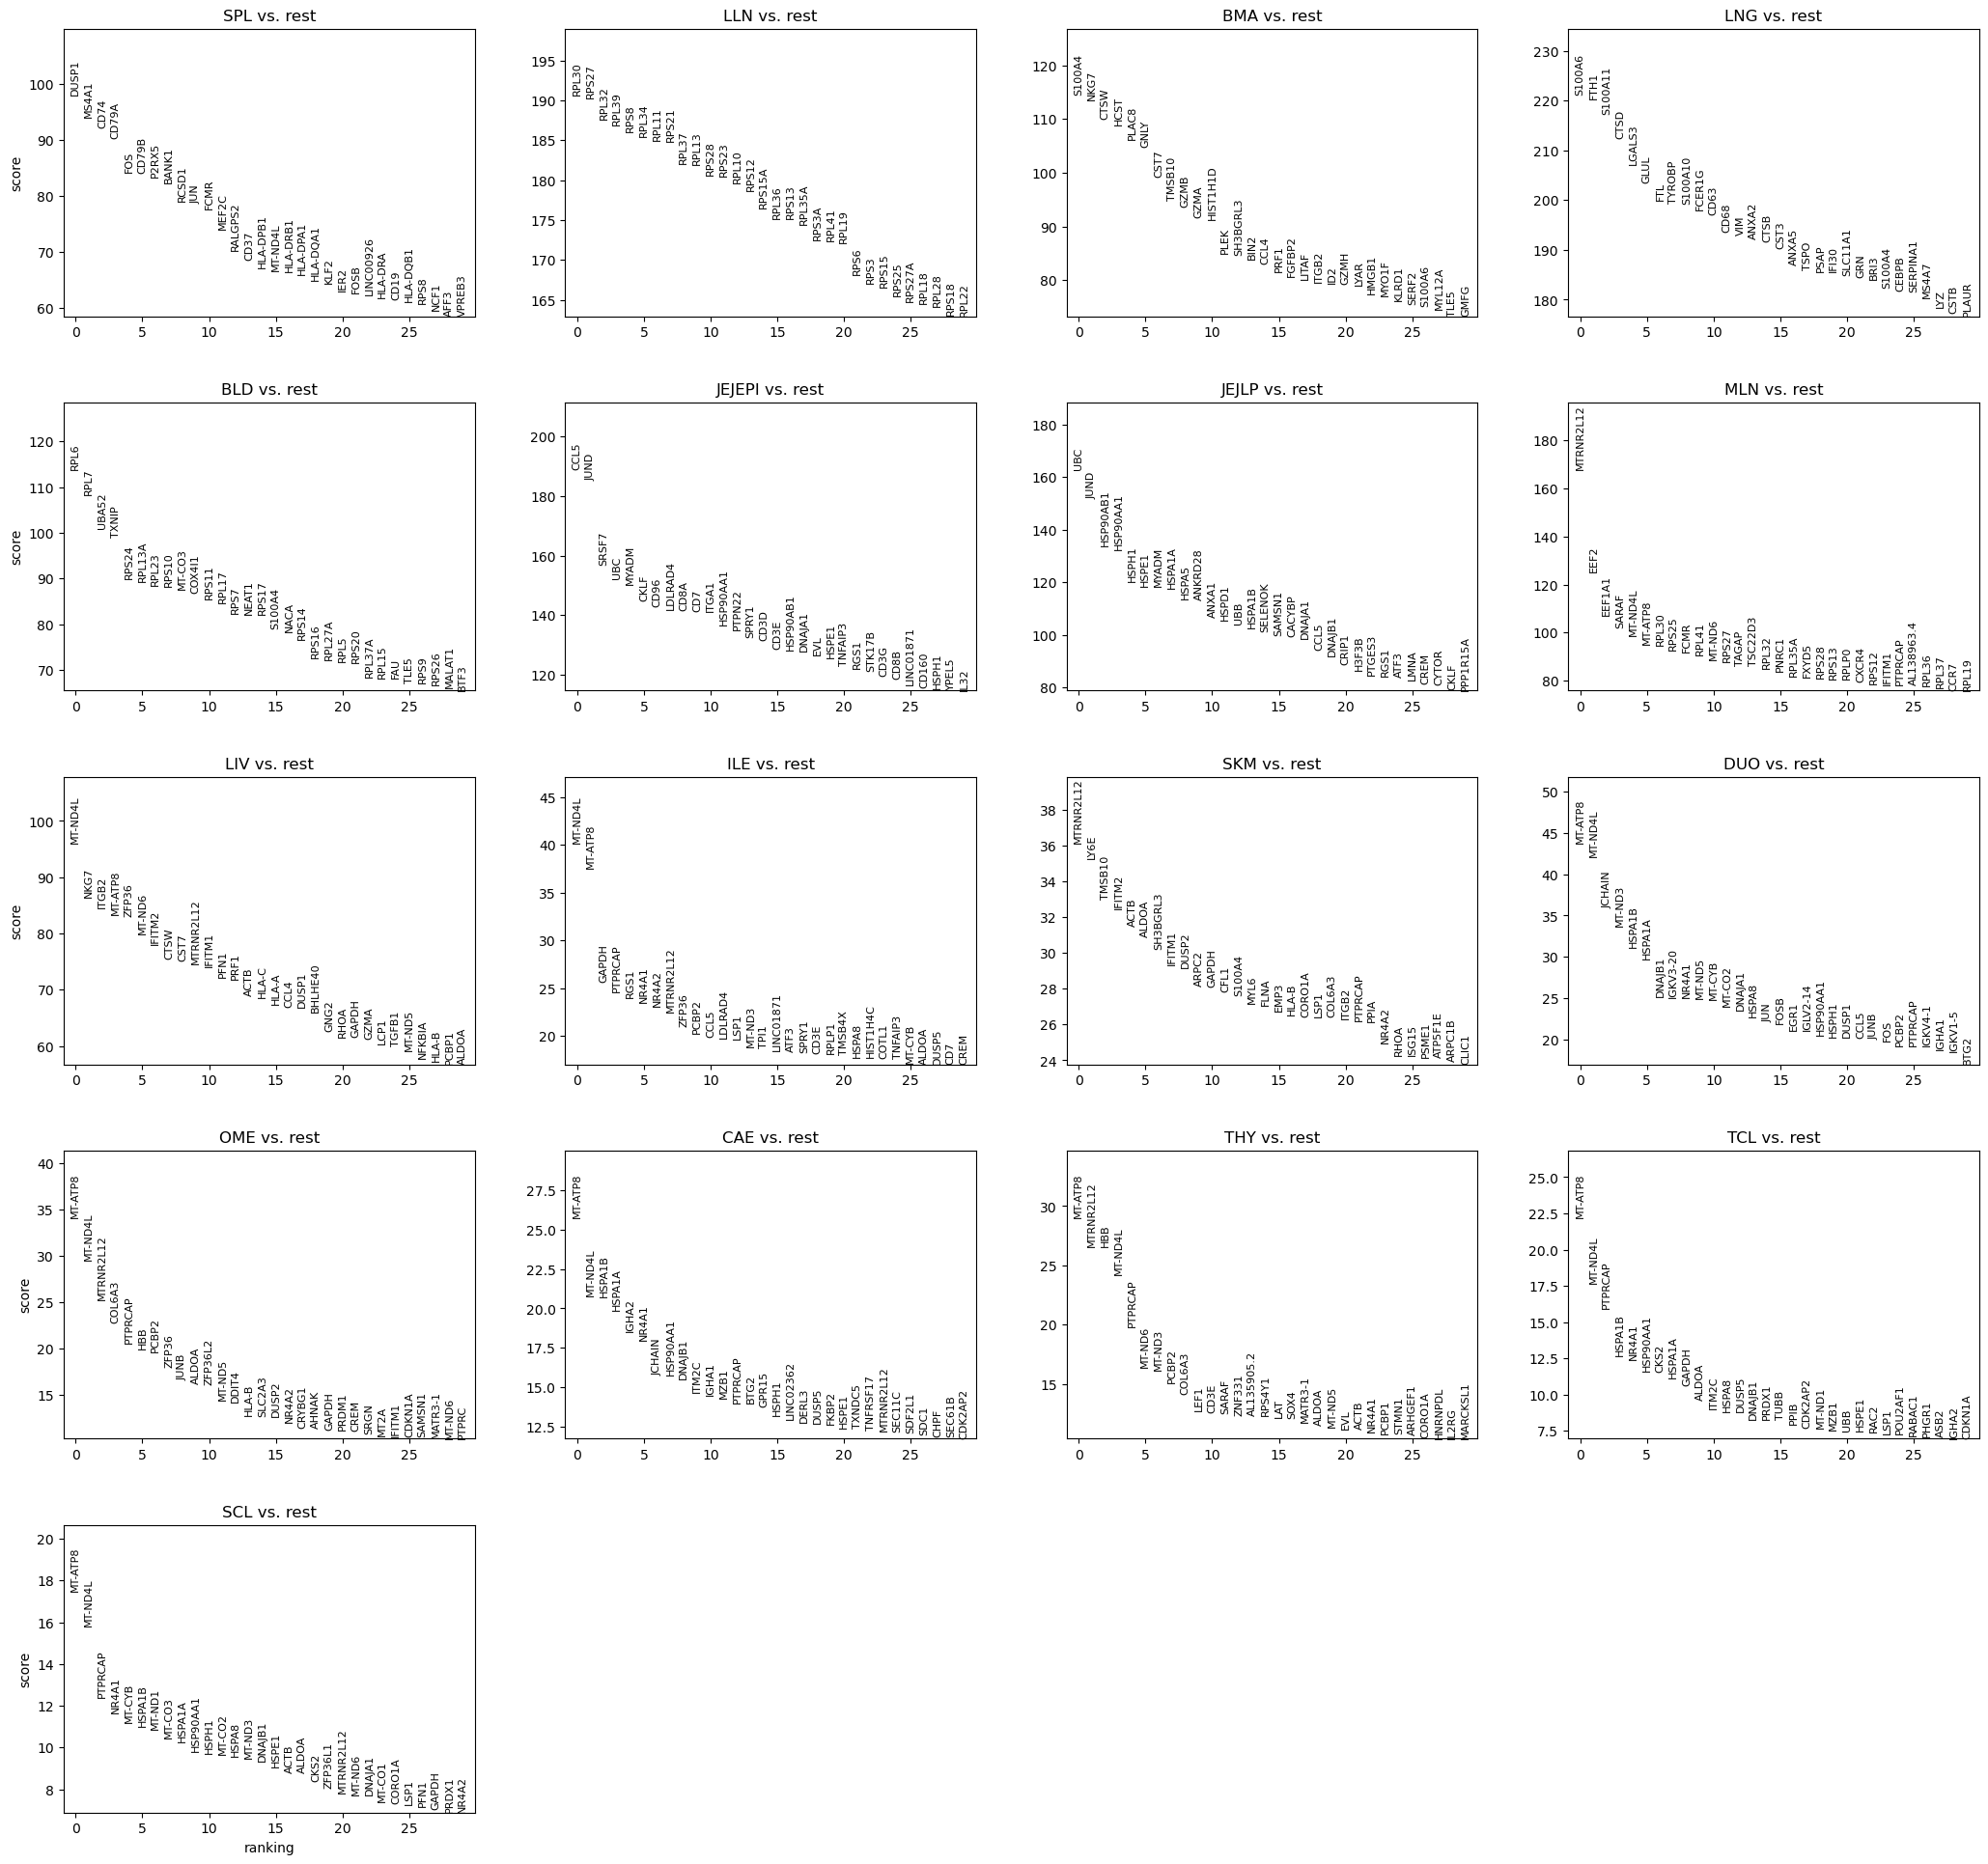

Top 5 genes for SPL: ['DUSP1' 'MS4A1' 'CD74' 'CD79A' 'FOS']
Top 5 genes for LLN: ['RPL30' 'RPS27' 'RPL32' 'RPL39' 'RPS8']
Top 5 genes for BMA: ['S100A4' 'NKG7' 'CTSW' 'HCST' 'PLAC8']
Top 5 genes for LNG: ['S100A6' 'FTH1' 'S100A11' 'CTSD' 'LGALS3']
Top 5 genes for BLD: ['RPL6' 'RPL7' 'UBA52' 'TXNIP' 'RPS24']
Top 5 genes for JEJEPI: ['CCL5' 'JUND' 'SRSF7' 'UBC' 'MYADM']
Top 5 genes for JEJLP: ['UBC' 'JUND' 'HSP90AB1' 'HSP90AA1' 'HSPH1']
Top 5 genes for MLN: ['MTRNR2L12' 'EEF2' 'EEF1A1' 'SARAF' 'MT-ND4L']
Top 5 genes for LIV: ['MT-ND4L' 'NKG7' 'ITGB2' 'MT-ATP8' 'ZFP36']
Top 5 genes for ILE: ['MT-ND4L' 'MT-ATP8' 'GAPDH' 'PTPRCAP' 'RGS1']
Top 5 genes for SKM: ['MTRNR2L12' 'LY6E' 'TMSB10' 'IFITM2' 'ACTB']
Top 5 genes for DUO: ['MT-ATP8' 'MT-ND4L' 'JCHAIN' 'MT-ND3' 'HSPA1B']
Top 5 genes for OME: ['MT-ATP8' 'MT-ND4L' 'MTRNR2L12' 'COL6A3' 'PTPRCAP']
Top 5 genes for CAE: ['MT-ATP8' 'MT-ND4L' 'HSPA1B' 'HSPA1A' 'IGHA2']
Top 5 genes for THY: ['MT-ATP8' 'MTRNR2L12' 'HBB' 'MT-ND4L' 'PTPRCAP']
Top 5 g

In [27]:
# Loop through each unique timepoint
# Check if there are any groups with fewer than 2 samples
group_counts = adata.obs['Organ'].value_counts()
valid_groups = group_counts[group_counts >= 2].index.tolist()
    
if len(valid_groups) > 0:
        # Perform differential expression analysis
        sc.tl.rank_genes_groups(adata, 'Organ', groups=valid_groups, method='wilcoxon')
        
        # Plot the ranked genes
        sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)
        
        # Extract the ranked genes
        result = adata.uns['rank_genes_groups']
        
        # Loop through each cell type and print the top 5 genes
        for cell_type in result['names'].dtype.names:
            top_genes = result['names'][cell_type][:5]
            print(f"Top 5 genes for {cell_type}: {top_genes}")

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


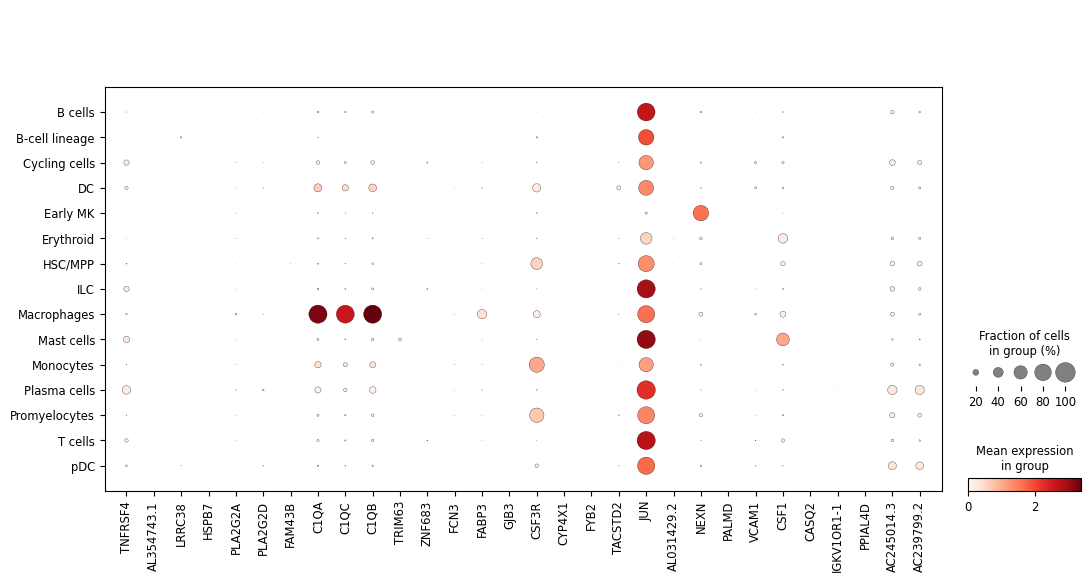

In [28]:
# visualize the top 30 highest expressed genes in a dotplot, focussing on the distribution of celltypes and organs
highest_expr_genes = adata.var_names[adata.var['highly_variable']]
top_30_genes = highest_expr_genes[:30]
sc.pl.dotplot(adata, top_30_genes, groupby="Majority_voting_CellTypist_high")
plt.show()

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


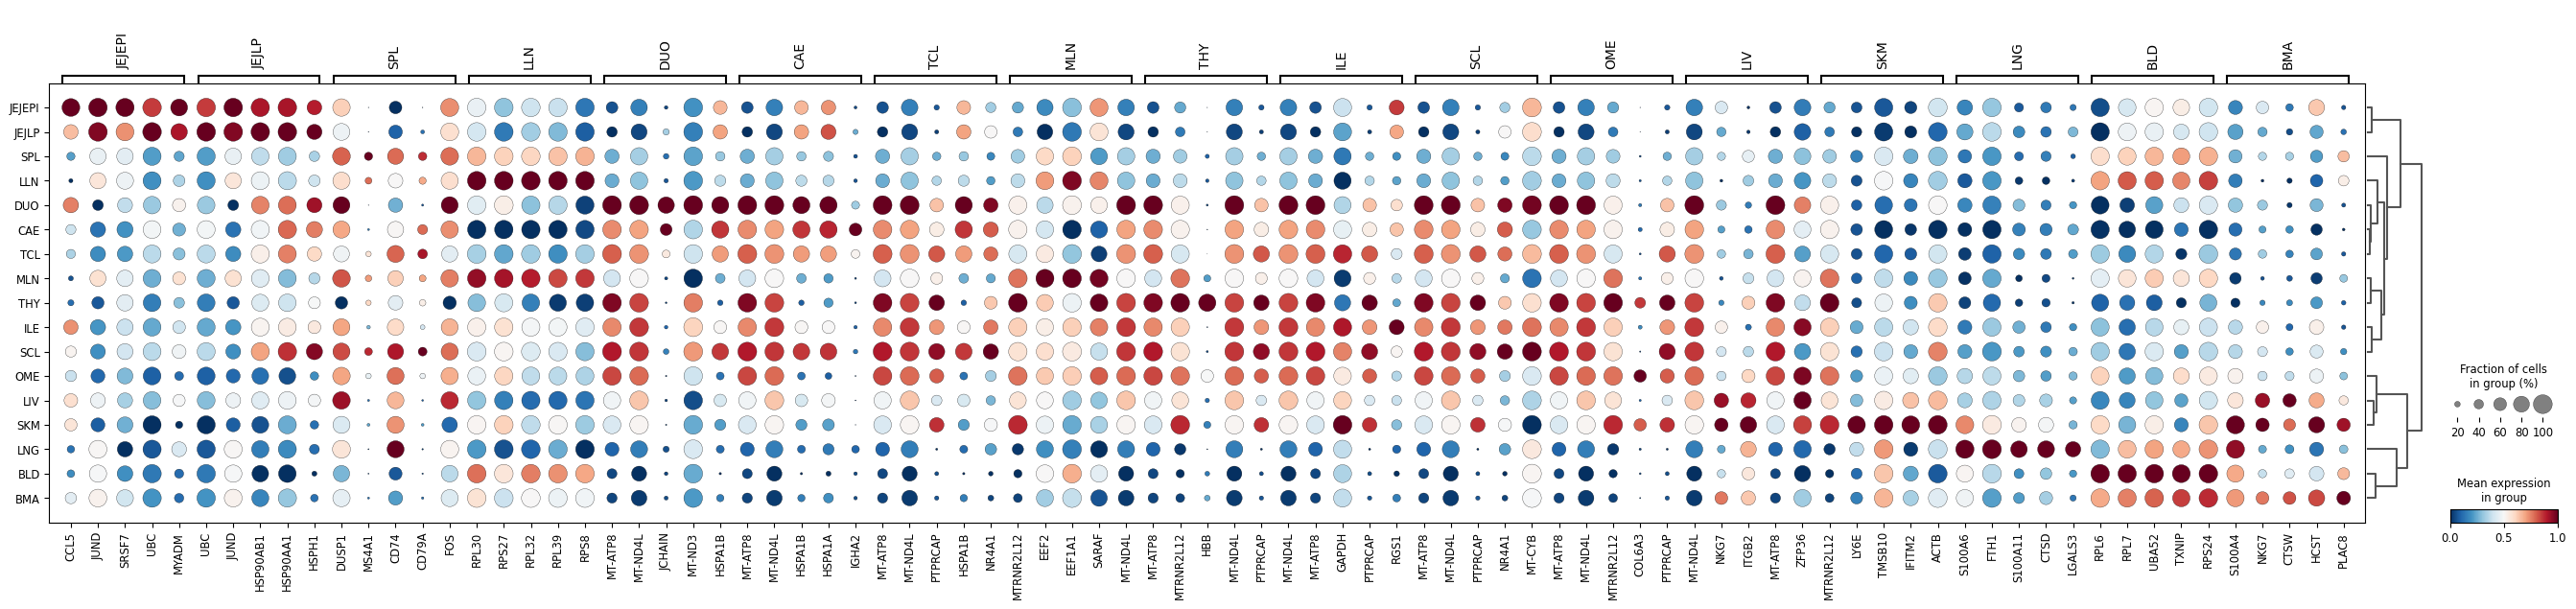

In [29]:
#For each celltype top 5 genes and their representation in the organs
sc.pl.rank_genes_groups_dotplot(adata, groupby="Organ", 
                                cmap='RdBu_r', n_genes=5, standard_scale='var')

In [ ]:
sc.tl.rank_genes_groups(adata, 'Organ', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

### Rank Gene Groups for only T Cells

In [ ]:
sc.tl.rank_genes_groups(adata_t, 'Organ', method='wilcoxon')
sc.pl.rank_genes_groups(adata_t, n_genes=30, sharey=False)
